# Seq2seq

Теория:

* [Attention](https://distill.pub/2016/augmented-rnns/)
* [Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html) (кодить его не надо)

Домашка будет не в формате «заполните пропуски в коде», а «напишите вообще всё сами» (ну, на самом деле не совсем всё — если вы делали ДЗ по языковым моделям, то большинство кода можно переиспользовать).

---

Решите *какую-нибудь* seq2seq-задачу: перевод, чат-бот, суммаризация etc.

Если вам лень искать свои данные, то возьмите:

* для машинного перевода — [европарламент](http://www.statmt.org/europarl/),
* для чат-бота — [Ubuntu Dialogue Corpus](https://github.com/rkadlec/ubuntu-ranking-dataset-creator).

Рекомендуется делать именно перевод: в нём не нужно неделями обучать сеть, чтобы получить хорошие результаты.

Финальная архитектура предлагается такая, но можете использовать что-то другое:

* GPU-encoder входной последовательности (возвращает последовательность векторов).
* Языковая модель на GRU, которая при генерации использует свой hidden, чтобы сделать запрос к закодированной последовательности, который возвращает какой-то вектор, который потом используется для получения распределения следующих токенов.
* Всё это обучается так же, как в языковых моделях, через teacher forcing.

Оценивание:

* Обработка и векторизация входа (совет: делайте токенизацию на уровне слов, а не символов) — 1 балл
* Как угодно работающая seq2seq-модель — 3 балла
* Прикрутить attention — 2 балла
* (Пообучайте модель с attention и без и сравните результаты)
* Анализ корреляции дискретных метрик (например, BLEU) с лоссом — 1 балл
* Клёвые реальные результаты, beam search, температура, другие токенизации — до 3 баллов

![seq2seq](https://cdn-images-1.medium.com/max/1600/1*sO-SP58T4brE9EHazHSeGA.png)


In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gc.collect()

5

### Preprocessing

In [3]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [6]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('/home/pavel/MyDocs/MachineLearning/Tinkoff/lecture8/translation_data/data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [7]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [8]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925
['tu es si pitoyable .', 'you re so pathetic .']


### Model

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [10]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [11]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [12]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### Training

In [13]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [14]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [15]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [16]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


In [17]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [18]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

### Training the model with attention:

In [21]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 100000, print_every=5000)

6m 2s (- 114m 56s) (5000 5%) 2.9022
10m 54s (- 98m 14s) (10000 10%) 2.3549
15m 35s (- 88m 23s) (15000 15%) 2.0149
20m 15s (- 81m 3s) (20000 20%) 1.7856
24m 57s (- 74m 52s) (25000 25%) 1.5967
29m 39s (- 69m 12s) (30000 30%) 1.3862
34m 21s (- 63m 48s) (35000 35%) 1.2702
39m 4s (- 58m 37s) (40000 40%) 1.1442
43m 48s (- 53m 32s) (45000 45%) 1.0404
48m 32s (- 48m 32s) (50000 50%) 0.9290
53m 17s (- 43m 35s) (55000 55%) 0.8693
58m 1s (- 38m 41s) (60000 60%) 0.8154
62m 45s (- 33m 47s) (65000 65%) 0.7174
67m 29s (- 28m 55s) (70000 70%) 0.6570
72m 12s (- 24m 4s) (75000 75%) 0.6020
76m 56s (- 19m 14s) (80000 80%) 0.5655
81m 39s (- 14m 24s) (85000 85%) 0.5145
113m 42s (- 12m 38s) (90000 90%) 0.4831
118m 34s (- 6m 14s) (95000 95%) 0.4324
123m 24s (- 0m 0s) (100000 100%) 0.4051


In [22]:
evaluateRandomly(encoder1, attn_decoder1)

> c est vous qui vous vous etes emballee .
= you re the one that went crazy .
< you re the one that went crazy . <EOS>

> ils sont la .
= they re here .
< they re here . <EOS>

> tu es fort contrariee .
= you re very upset .
< you re very upset . <EOS>

> je suis en train de me peser .
= i am weighing myself .
< i am drowning . <EOS>

> ma curiosite commence a s aiguiser .
= i m beginning to get curious .
< i m beginning to get curious . <EOS>

> nous sommes prudents .
= we re careful .
< we re careful . <EOS>

> je suis desolee mon pere est elimine .
= i m sorry my father is out .
< i m sorry my father is out . <EOS>

> je suis desole si je vous ai derangee .
= i m sorry if i disturbed you .
< i m sorry if i disturbed you . <EOS>

> je suis soulage d entendre cela .
= i m relieved to hear that .
< i m sorry to hear that . <EOS>

> tu es sur le chemin de la reussite .
= you re on the path of success .
< you re on the path of success . <EOS>



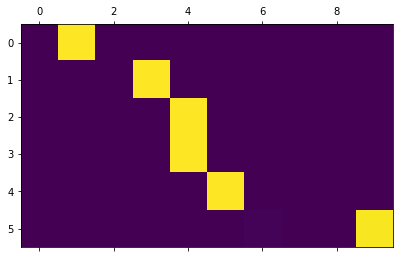

In [31]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
#plt.cla()
#plt.plot(attentions.numpy())
plt.matshow(attentions.numpy())
plt.show()
#plt.savefig('attentions.pdf')

input = elle a cinq ans de moins que moi .
output = she s five to younger than me . . <EOS>


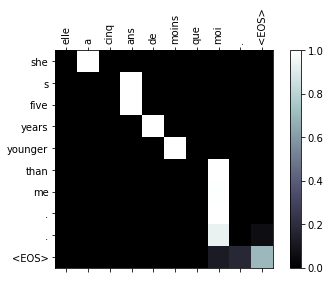

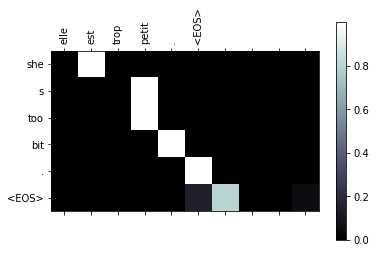

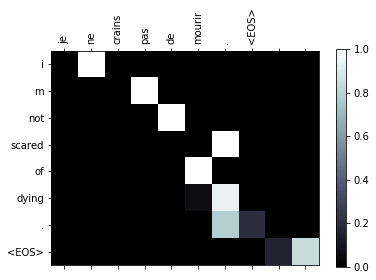

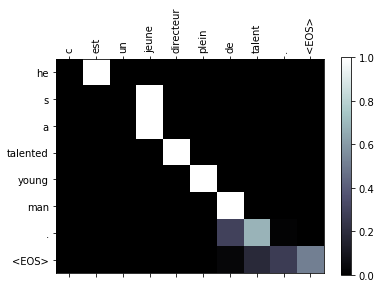

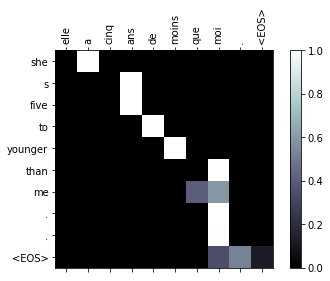

input = elle est trop petit .
output = she s too bit . <EOS>


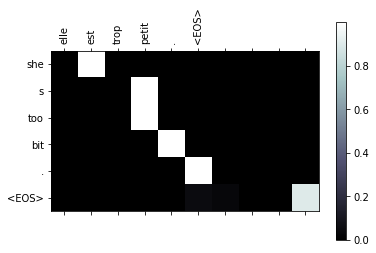

input = je ne crains pas de mourir .
output = i m not scared of dying . <EOS>


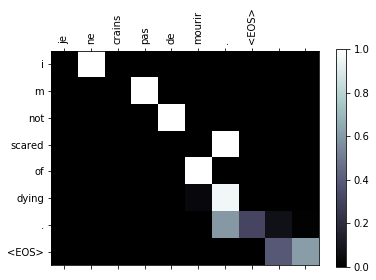

input = c est un jeune directeur plein de talent .
output = he s a great young man . <EOS>


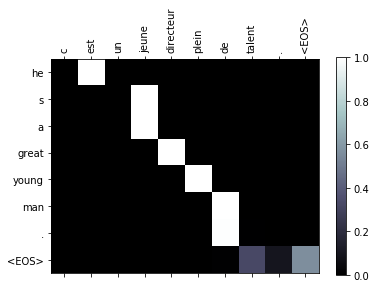

In [29]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

### Now let's count BLEU score

In [47]:
BLEUscore = 0
for pair in pairs:
    output_words, attentions = evaluate(encoder1, attn_decoder1, pair[0])
    hypothesis = output_words
    reference = pair[1].split(' ')
    BLEUscore += nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
BLEUscore /= len(pairs)
print(BLEUscore)

/home/pavel/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/home/pavel/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/home/pavel/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.7042955499606223
